# Predicting the number of customers at restaurants in Japan

Data is provided by FPT Software

In [1]:
# import libraries 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime
from fbprophet import Prophet
from sklearn import preprocessing 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import os
%matplotlib inline


import warnings;
warnings.simplefilter('ignore')


In [2]:
# load data in 
df = pd.read_csv('/Users/nadiaparsell/csv_files/train_restaurant_visitors.csv')

# Step 1: Exploratory data analysis 

In [3]:
# check the dataframe
df

,date,store_id,number_of_visitors,day_of_week,holiday_flag,area,type,latitude,longitude,zipcode
0,2016-01-01,air_fab092c35776a9b1,19,Friday,1,Fukuoka-ken Fukuoka-shi Momochi,Cafe/Sweets,33.581941,130.348436,814-0006
1,2016-01-01,air_f26f36ec4dc5adb0,64,Friday,1,Tōkyō-to Shinjuku-ku Kabukichō,Izakaya,35.693840,139.703549,160-0021
2,2016-01-01,air_d97dabf7aae60da5,102,Friday,1,Tōkyō-to Shibuya-ku Jingūmae,Cafe/Sweets,35.669290,139.707056,150-0001
3,2016-01-01,air_39dccf7df20b1c6a,55,Friday,1,Hyōgo-ken Takarazuka-shi Tōyōchō,Izakaya,34.799767,135.360073,665-0032
4,2016-01-01,air_79f528087f49df06,42,Friday,1,Tōkyō-to Suginami-ku Asagayaminami,Western food,35.699566,139.636438,166-0004
...,...,...,...,...,...,...,...,...,...,...
174530,2016-12-31,air_399904bdb7685ca0,18,Saturday,1,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,Italian/French,34.681261,135.509801,541-0056
174531,2016-12-31,air_78df4dc6a7e83e41,29,Saturday,1,Tōkyō-to Kita-ku Ōjihonchō,Cafe/Sweets,35.752804,139.733480,114-0022
174532,2016-12-31,air_8f3b563416efc6ad,13,Saturday,1,Tōkyō-to Shinjuku-ku Kabukichō,Izakaya,35.693840,139.703549,160-0021
174533,2016-12-31,air_9828505fefc77d75,15,Saturday,1,Fukuoka-ken Fukuoka-shi Daimyō,Cafe/Sweets,33.589216,130.392813,810-0041


Looking at the 10 rows above, it seems like the date ranges from  2016-01-01 to 2016-12-31 and I will be forecasting the number of customers for the next 15 days based on the data available per store. I think it is reasonable to assume that the number of customers vary by the day of the week, the type of store, what area the store is located, and also if it is a holiday or not.  

In [4]:
# check for data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174535 entries, 0 to 174534
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                174535 non-null  object 
 1   store_id            174535 non-null  object 
 2   number_of_visitors  174535 non-null  int64  
 3   day_of_week         174535 non-null  object 
 4   holiday_flag        174535 non-null  int64  
 5   area                174535 non-null  object 
 6   type                174535 non-null  object 
 7   latitude            174535 non-null  float64
 8   longitude           174535 non-null  float64
 9   zipcode             174535 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 13.3+ MB


There are no missing data. However, I need to transform the date column into datetime for analysis later on. 

In [5]:
# check the number of unique values in each column
for column in df.columns:
    print(df[column].value_counts())
    print('------------------------------------------')

2016-11-18    783
2016-12-16    782
2016-10-21    779
2016-10-14    778
2016-12-09    777
             ... 
2016-01-24    202
2016-01-04    157
2016-01-03     81
2016-01-02     63
2016-01-01     48
Name: date, Length: 366, dtype: int64
------------------------------------------
air_36bcf77d3382d36e    365
air_232dcee6f7c51d37    365
air_a083834e7ffe187e    365
air_5c817ef28f236bdf    365
air_d97dabf7aae60da5    364
                       ... 
air_31c753b48a657b6c     17
air_965b2e0cf4119003     15
air_2a485b92210c98b5     12
air_789103bf53b8096b      2
air_7420042ff75f9aca      1
Name: store_id, Length: 819, dtype: int64
------------------------------------------
8      5987
6      5923
10     5906
9      5876
7      5867
       ... 
161       1
229       1
207       1
409       1
183       1
Name: number_of_visitors, Length: 188, dtype: int64
------------------------------------------
Friday       27889
Saturday     27010
Thursday     26178
Wednesday    25576
Tuesday      25086
Monday

-The date column suggests that each store has a different number of data points 

-There value counts column indicates that there are over 800 unique stores. The value counts column also confirms that each store has a different number of data points

-It may be useful to take the prefecture string out of the area column since the area column includes prefecture, ward, and neighborhood

-There are 14 different types of stores, with the most data on izakayas, cafe/sweets, dining bar, and Italian/French. There is sparse data on Asian, karoke/party, and international cuisine

-The latitude, longitude, and zip code may be useful later for adding in weather data to the model

In [ ]:
# Delete the two stores with less than 3 data points 
df = df[df['store_id'] != 'air_7420042ff75f9aca' ]
df = df[df['store_id'] != 'air_789103bf53b8096b']
df.shape

In [6]:
# Add another column with prefectures
df['prefecture'] = df['area'].str.split(' ').str[0]

df['prefecture'].value_counts()

Tōkyō-to         91846
Fukuoka-ken      27561
Ōsaka-fu         15769
Hyōgo-ken        12270
Hokkaidō          8914
Hiroshima-ken     6921
Miyagi-ken        4323
Shizuoka-ken      4095
Niigata-ken       2836
Name: prefecture, dtype: int64

Most of the store are located in Tokyo

In [7]:
# change to datetime 
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

<AxesSubplot:xlabel='date', ylabel='number_of_visitors'>

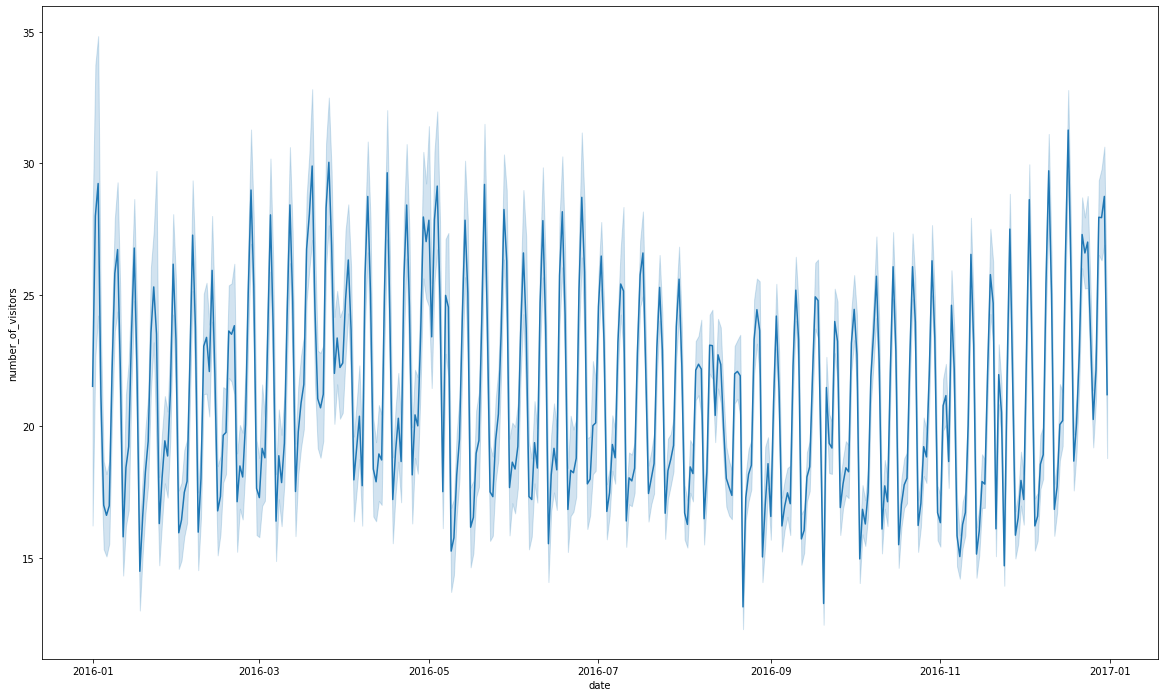

In [8]:
# Quick look at the number of customers overtime 
fig, ax1 = plt.subplots(1, figsize=(20, 12))
sns.lineplot(data=df, x='date', y='number_of_visitors')

The number of customers over the span of the year seems to be stationary. However, there are many spikes and dips, suggesting that there is weekly seaonsality

day_of_week
Friday       23.069131
Monday       17.190598
Saturday     26.079859
Sunday       23.856025
Thursday     19.249217
Tuesday      17.725464
Wednesday    19.345402
Name: number_of_visitors, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


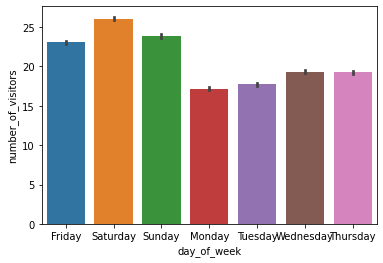

In [9]:
# Check to see if number of customers vary by day of the week  

print(df.groupby('day_of_week')['number_of_visitors'].mean())

print(sns.barplot(x='day_of_week', y='number_of_visitors', data=df))
plt.show()

Compared to the weekdays, the average number of customers are greater on Friday, Saturday, and Sunday. 

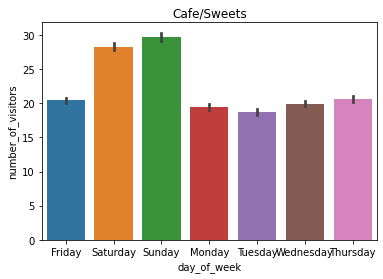

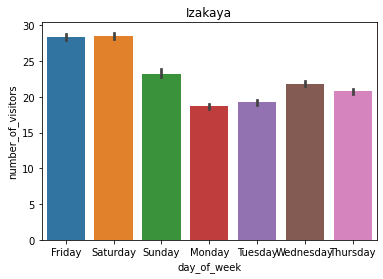

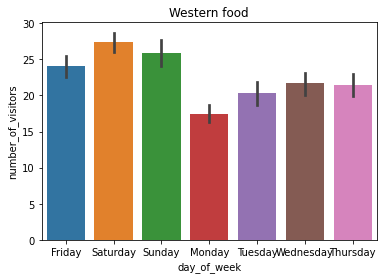

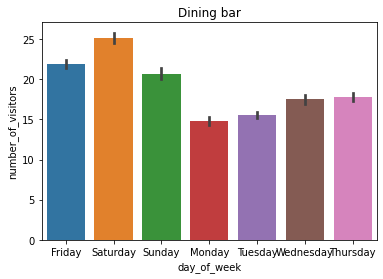

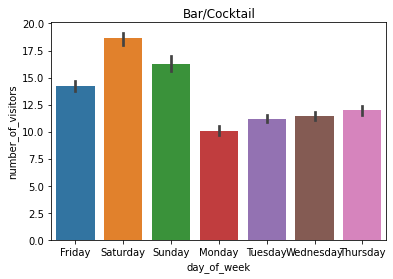

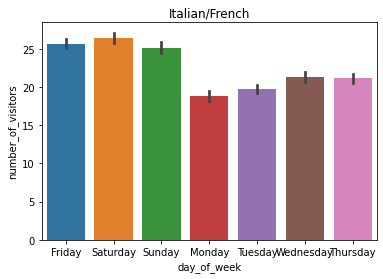

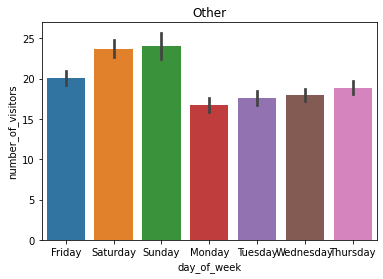

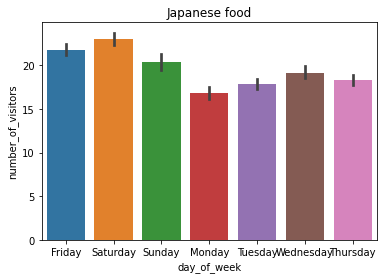

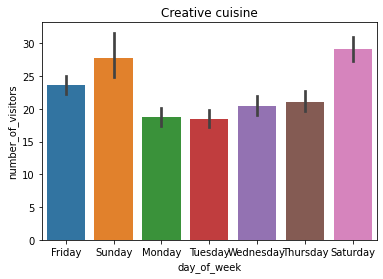

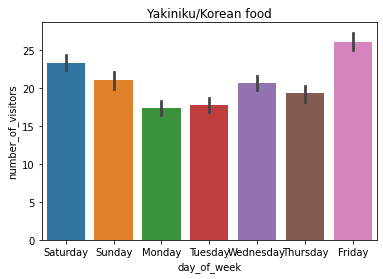

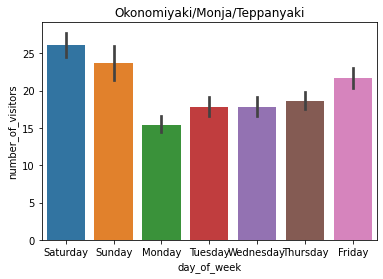

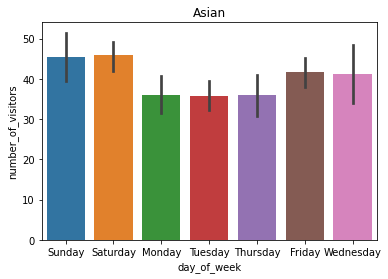

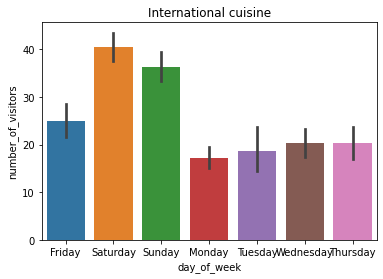

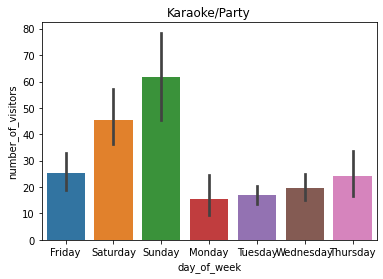

In [10]:
# Check to see if the average number of customers vary by type of store over the week

venue_type = df['type'].unique()

for venue in venue_type:
    filt = (df['type'] == venue)
    sns.barplot(x='day_of_week', y='number_of_visitors', data=df[filt]).set(title=venue)
    plt.show()

Clear weekly seasonality. While Friday, Saturday, and Sunday seem to be the most popular days for each store, there is quite a bit of variation. 

In addition, the average number of customers may vary by prefecture

In [11]:
# Check if the average number of customers vary by type of store and prefecture
# make a series with just the prefecture names 
prefectures = df['prefecture'].unique()

# For each prefecture, mean number of customers, mean number of customers per day of week,
# and the number of stores

for prefecture in prefectures:
    filt = (df['prefecture'] == prefecture)
    print(prefecture)
    print(df[filt].groupby('day_of_week')['number_of_visitors'].mean())
    print('Mean number of visitors per day of week: ' + str(df[filt]['number_of_visitors'].mean()))
    print('Number of stores: ' + str(df[filt]['store_id'].nunique()))
    print('-----------------------')

Fukuoka-ken
day_of_week
Friday       22.479257
Monday       17.726862
Saturday     26.379068
Sunday       22.223386
Thursday     18.674413
Tuesday      17.280459
Wednesday    18.947249
Name: number_of_visitors, dtype: float64
Mean number of visitors per day of week: 20.637095896375314
Number of stores: 127
-----------------------
Tōkyō-to
day_of_week
Friday       22.440545
Monday       16.820281
Saturday     23.791957
Sunday       22.909188
Thursday     19.371352
Tuesday      17.959250
Wednesday    19.473852
Name: number_of_visitors, dtype: float64
Mean number of visitors per day of week: 20.423001546066242
Number of stores: 437
-----------------------
Hyōgo-ken
day_of_week
Friday       25.322182
Monday       18.557741
Saturday     30.388223
Sunday       28.104953
Thursday     20.077216
Tuesday      18.483035
Wednesday    20.528043
Name: number_of_visitors, dtype: float64
Mean number of visitors per day of week: 23.285819070904644
Number of stores: 55
-----------------------
Miyagi-ken

-Seems to be some variation

-Most of the stores are in Tokyo and Fukuoka

In [12]:
# There is clear weekly seasonality so I will add in a column with numerical values for the day of the week
df['num_day_of_week'] = df['day_of_week'].replace(['Monday', 'Tuesday', 'Wednesday','Thursday',
                               'Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

In [13]:
# Since we have the prefecture, we can take the area out of the dataframe 

df_main = df[df.columns[~df.columns.isin(['area'])]]

In [14]:
print(df_main.dtypes)

df_main.head()

date                  datetime64[ns]
store_id                      object
number_of_visitors             int64
day_of_week                   object
holiday_flag                   int64
type                          object
latitude                     float64
longitude                    float64
zipcode                       object
prefecture                    object
num_day_of_week                int64
dtype: object


,date,store_id,number_of_visitors,day_of_week,holiday_flag,type,latitude,longitude,zipcode,prefecture,num_day_of_week
0,2016-01-01,air_fab092c35776a9b1,19,Friday,1,Cafe/Sweets,33.581941,130.348436,814-0006,Fukuoka-ken,5
1,2016-01-01,air_f26f36ec4dc5adb0,64,Friday,1,Izakaya,35.693840,139.703549,160-0021,Tōkyō-to,5
2,2016-01-01,air_d97dabf7aae60da5,102,Friday,1,Cafe/Sweets,35.669290,139.707056,150-0001,Tōkyō-to,5
3,2016-01-01,air_39dccf7df20b1c6a,55,Friday,1,Izakaya,34.799767,135.360073,665-0032,Hyōgo-ken,5
4,2016-01-01,air_79f528087f49df06,42,Friday,1,Western food,35.699566,139.636438,166-0004,Tōkyō-to,5


# Step 2: Modeling 

I will be using the Facebook Prophet model in order to forecast the number of customers for the next 15 days for each store. I have chosen Facebook Prophet for several reasons: 

(1) I need a model that is fast since there are 891 stores to forecast

(2) Relatively easy to add in regressors. In addition, Facebook prophet has a built in collections of holidays for each country

(3) Can handle missing data. Although there are no null values in the dataset, it is clear that most stores do not have data for each day between 2016-01-01 and 2016-12-31

# Function that forecasts the number of customers for each store: 

This function below returns a dictionary consisting of store ID and four time series performance metrics (MAPE, MAE, MSE, RMSE). The arguments are the (1)dataframe and (2)number of days to forecast. The dataframe requires the columns: store ID, number of customers, and the numerical day of the week. The user can specify the number of days they wish to forecast in the second argument.


Description of model: 
I decided to train the model using the first 80% of the data and test using the last 20%. First, I tested a univariate model and then compared performance using several different regressors. I included holidays and day of the week since the model exhibited better performance with these two regressors. I excluded temperature data since it resulted in worse performance for several stores in the Tokyo area. Furthermore, I saw that several of the stores had negative predicted values for number of customers so I set the model to have logistic growth with the floor value as 1 and the carrying capacity as the maximum number of customers seen in the training set + 20 (incase the store exhibited linear growth).   


Performance of model and future improvements: 
The performance of the model varied widely. The stores that performed the best seemed to have more data and also had little to no outliers. However, the stores that performed poorly had large outliers in the testing set. Removing large and random outliers through anomaly detection may improve performance in the future. Furthermore, adding in whether the day is sunny, rainy, or snowy may improve the model. In addition, I set the model to logistic growth, since I did not exhibit upward trends. However, it may be best to consult with a domain expert on this topic. 

In [36]:
def forecast_all_stores(dataframe, num_days_forecast):
    # run the first three stores as an example 
    stores = dataframe['store_id'].unique()[:5] # forecast for 5 days as an example
    
    # Create empty lists for performance metrics and store ID
    mape_results_by_store = [] 
    mae_results_by_store = []
    mse_results_by_store = []
    rmse_results_by_store =[] 
    stores_list = []
    
    for store in stores: 
        # forecast next 15 days for each store 
        df_store = dataframe[dataframe['store_id'] == store]
        
        # select columns needed and rename columns for prophet model
        df_store = df_store[['date','number_of_visitors','num_day_of_week']]
        df_store.columns = ['ds','y','num_day_of_week']

        # create training and testing sets (80/20)
        train = df_store.iloc[0: (int(len(df_store)*.8))] #80% of data
        test = df_store.iloc[(int(len(df_store)*.8)) : len(df_store)] #20% of data

        # prepare prediction dataset
        future = df_store[['ds','num_day_of_week']]
        future.reset_index(drop=True , inplace=True)

        # set carrying capacity and floor so we don't get negative values for customers 
        train['cap'] = (train['y'].max() + 20)
        train['floor'] = 1
        future['cap'] = (train['y'].max() + 20) 
        future['floor'] = 1

        #### insantiate the model ####
        # add weekly seasonality, 95% CI, and logistic growth 
        m = Prophet(daily_seasonality = False, weekly_seasonality = True, interval_width = 0.95,
                   growth='logistic') 
        # add regressors
        m.add_country_holidays(country_name='Japan') # Japanese holidays
        m.add_regressor('num_day_of_week', standardize = False) # day of week

        # fit the model
        m.fit(train)

        # forecast 
        forecast = m.predict(future)

        # Predicted number of customers  
        predicted_num_customers = forecast.tail(len(test))
        predicted_num_customers = pd.Series(predicted_num_customers['yhat'].values)
        
        # Performance metric 
        mape_vals = mean_absolute_percentage_error(test['y'].values, predicted_num_customers)
        mape_results_by_store.append(mape_vals)
        # MAE
        mae_vals = mean_absolute_error(test['y'].values, predicted_num_customers)
        mae_results_by_store.append(mae_vals)
        # MSE
        mse_vals = mean_squared_error(test['y'].values, predicted_num_customers, squared = True)
        mse_results_by_store.append(mse_vals)
        # RMSE 
        rmse_vals = mean_squared_error(test['y'].values, predicted_num_customers, squared = False)
        rmse_results_by_store.append(rmse_vals)
        
        # Stores list
        stores_list.append(store)
        
        
        
        ####################### Predict for future #############################
        df_store['cap'] = (df_store['y'].max() + 20)
        df_store['floor'] = 1

        m2 = Prophet(daily_seasonality = False, weekly_seasonality = True, interval_width = 0.95,
                   growth='logistic')
        # add regressor
        m2.add_country_holidays(country_name='Japan')
        m2.add_regressor('num_day_of_week', standardize = False)

        # fit the model 
        m2.fit(df_store)

        # make forecast dataset with the appropriate regressors
        future2 = m2.make_future_dataframe(periods = num_days_forecast)
        future2['day_of_week'] = future2['ds'].dt.day_name()
        future2['num_day_of_week'] = future2['day_of_week'].replace(['Monday', 'Tuesday', 'Wednesday','Thursday',
                                       'Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

        future2 = future2[['ds','num_day_of_week']]

        # set ceiling and floor to prevent negative predictions 
        future2['cap'] = (df_store['y'].max() + 20)
        future2['floor'] = 1

        ##### predict the next x days #####
        pred_values = m2.predict(future2)
        forecast_excel = pred_values[['ds','yhat']]
        print(store)
        print(pred_values[['ds','yhat']].tail(15))
        print('-----------------------------------')
    
    # Return store_id and performance metrics 
    return {'Store_ID': stores_list, 'MAPE': mape_results_by_store, 'MAE': mae_results_by_store, 'MSE': mae_results_by_store, 
           'RMSE': rmse_results_by_store}


I will forecast five stores as an example since there are many stores and the facebook prophet model comes with the large red warnings that cannot be easily disabled. 

In [37]:
# Run function
forecast_store_results = forecast_all_stores(df_main, 15)

# convert to dataframe and export it to excel 
df_by_store = pd.DataFrame(forecast_store_results)
df_by_store
#df_by_store.to_excel('forecast_all_stores_trial.xlsx')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


air_fab092c35776a9b1
            ds       yhat
348 2017-01-01  21.944534
349 2017-01-02  14.092888
350 2017-01-03   9.802678
351 2017-01-04  10.795147
352 2017-01-05  10.638730
353 2017-01-06  10.162245
354 2017-01-07  13.951247
355 2017-01-08  13.156285
356 2017-01-09  10.133591
357 2017-01-10   9.802681
358 2017-01-11  10.795150
359 2017-01-12  10.638734
360 2017-01-13  10.162248
361 2017-01-14  13.951250
362 2017-01-15  13.156289
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


air_f26f36ec4dc5adb0
            ds       yhat
354 2017-01-01  69.213600
355 2017-01-02  86.932538
356 2017-01-03  29.130082
357 2017-01-04  31.523079
358 2017-01-05  29.864642
359 2017-01-06  38.795442
360 2017-01-07  53.456472
361 2017-01-08  47.406891
362 2017-01-09  39.880631
363 2017-01-10  29.071585
364 2017-01-11  31.464585
365 2017-01-12  29.806151
366 2017-01-13  38.736954
367 2017-01-14  53.397987
368 2017-01-15  47.348409
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


air_d97dabf7aae60da5
            ds        yhat
364 2017-01-01  101.373699
365 2017-01-02   57.186928
366 2017-01-03   10.552534
367 2017-01-04   13.928662
368 2017-01-05   13.578028
369 2017-01-06   13.430554
370 2017-01-07   48.748805
371 2017-01-08   49.089052
372 2017-01-09   38.563610
373 2017-01-10   10.145656
374 2017-01-11   13.523058
375 2017-01-12   13.173693
376 2017-01-13   13.027487
377 2017-01-14   48.347003
378 2017-01-15   48.688511
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


air_39dccf7df20b1c6a
            ds       yhat
362 2017-01-01  61.860778
363 2017-01-02  26.072421
364 2017-01-03  20.238870
365 2017-01-04  21.598624
366 2017-01-05  21.610505
367 2017-01-06  24.132809
368 2017-01-07  31.734986
369 2017-01-08  30.878390
370 2017-01-09  30.622046
371 2017-01-10  20.241948
372 2017-01-11  21.601703
373 2017-01-12  21.613583
374 2017-01-13  24.135888
375 2017-01-14  31.738064
376 2017-01-15  30.881468
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


air_79f528087f49df06
            ds       yhat
315 2017-01-01  58.598744
316 2017-01-02  16.555182
317 2017-01-03   7.950824
318 2017-01-04   9.892956
319 2017-01-05   8.716457
320 2017-01-06  11.167598
321 2017-01-07  40.826277
322 2017-01-08  44.275473
323 2017-01-09  38.310056
324 2017-01-10   7.527353
325 2017-01-11   9.469426
326 2017-01-12   8.292869
327 2017-01-13  10.743952
328 2017-01-14  40.402575
329 2017-01-15  43.851716
-----------------------------------


,Store_ID,MAPE,MAE,MSE,RMSE
0,air_fab092c35776a9b1,0.380407,3.926116,3.926116,5.431378
1,air_f26f36ec4dc5adb0,0.234151,8.229649,8.229649,10.582287
2,air_d97dabf7aae60da5,0.380132,10.646811,10.646811,15.450498
3,air_39dccf7df20b1c6a,0.475901,7.587126,7.587126,9.447476
4,air_79f528087f49df06,0.704527,7.874957,7.874957,10.437059


# Function that forecasts the number of customers by prefecture and type of store: 

This function below returns a dictionary consisting of prefecture, type of store, and four time series performance metrics (MAPE, MAE, MSE, RMSE). The arguments are the (1)dataframe and (2)number of days to forecast. The dataframe requires the columns: store ID, number of customers, and the numerical day of the week. The user can specify the number of days they wish to forecast in the second argument.

Thought process: I suspect the previous model was heavily influenced by outliers so I found the mean number of customers by the type of store in each prefecture. This time, I did not set the model for logistic growth since it is unlikely the model will predict negative values since I am taking the average number of customers. The rest of the model is identical to the previous model. 
  

Performance of model and future improvements: 
The model overall performed much better when aggregating the data. If the stores in this dataset are from a conglomerate then it may be useful to also look at these results to see the future predicted number of customers by the type of store in each prefecture. 

In [28]:
def forecast_by_type(dataframe, num_days_forecast):
    prefectures = dataframe['prefecture'].unique()[:1] # forecast by type of store in Fukuoka as an example

    # performance metric 
    mape_results_by_type = []
    mae_results_by_type = []
    mse_results_by_type = []
    rmse_results_by_type =[] 
    prefectures_list = []
    stores_list = []

    for prefecture in prefectures:
        
        df_prefecture = dataframe[dataframe['prefecture'] == prefecture]
        stores = df_prefecture['type'].unique()
        
        for store in stores:
            df = df_prefecture[df_prefecture['type'] == store]
            
            # keep these columns 
            df = df[['date','number_of_visitors','num_day_of_week']]
            df = df.groupby('date')[['number_of_visitors','num_day_of_week']].mean()
            df.index.names = ['ds']
            df = df.reset_index(drop=False)
            df.columns = ['ds','y','num_day_of_week']

            # training 
            train = df.iloc[0: (int(len(df)*.8))] # train with the first 80% of the data

            # testing
            test = df.iloc[(int(len(df)*.8)) : len(df)] # test with the last 20% of the data
            test = test.reset_index(drop=True)

            # insantiate the model 
            m = Prophet(daily_seasonality = False, weekly_seasonality = True,interval_width = 0.95)
            # add regressors
            m.add_country_holidays(country_name='Japan') # add holidays 
            m.add_regressor('num_day_of_week', standardize = False) # add day of the week
            

            # fit the model 
            m.fit(train)

            # forecast 
            forecast = m.predict(test)
            
            # Predicted values 
            predicted_num_customers = forecast.tail(len(test))
            predicted_num_customers = pd.Series(predicted_num_customers['yhat'].values)
            
            ### Calculate performance metrics and append results ### 
            # MAPE
            mape_vals = mean_absolute_percentage_error(test['y'].values,predicted_num_customers)
            mape_results_by_type.append(mape_vals)
            # MAE
            mae_vals = mean_absolute_error(test['y'].values,predicted_num_customers)
            mae_results_by_type.append(mae_vals)
            # MSE
            mse_vals = mean_squared_error(test['y'].values,predicted_num_customers, squared = True)
            mse_results_by_type.append(mse_vals)
            # RMSE 
            rmse_vals = mean_squared_error(test['y'].values,predicted_num_customers, squared = False)
            rmse_results_by_type.append(rmse_vals)
            
            # Append type of store and prefecture to list  
            stores_list.append(store)
            prefectures_list.append(prefecture)

            ###################### predict for future ######################
            m2 = Prophet(daily_seasonality = False, weekly_seasonality = True, interval_width = 0.95)
            # add regressor
            m2.add_country_holidays(country_name='Japan')
            m2.add_regressor('num_day_of_week', standardize = False)

            # fit the model 
            m2.fit(df)

            # make forecast dataset with the appropriate regressors
            future2 = m2.make_future_dataframe(periods = num_days_forecast)
            future2['day_of_week'] = future2['ds'].dt.day_name()
            future2['num_day_of_week'] = future2['day_of_week'].replace(['Monday', 'Tuesday', 'Wednesday','Thursday',
                                           'Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])


            future2 = future2[['ds','num_day_of_week']]

            ##### predict the next x days #####
            pred_values = m2.predict(future2) 
            #forecast_vals = pred_values['yhat']
            print(prefecture, store)
            print(pred_values[['ds','yhat']].tail(15))
            print('-----------------------------------')
            
    return {'Prefecture': prefectures_list, 'Type of store': stores_list, 'MAPE': mape_results_by_type, 'MAE': mae_results_by_type, 'MSE': mae_results_by_type, 
           'RMSE': rmse_results_by_type}

I will forecast by type of store in Fukuoka prefecture as an example

In [29]:
# Run function
df_by_type = forecast_by_type(df_main, 15)

# Convert to dataframe and export to excel 
df_by_type = pd.DataFrame(df_by_type)
df_by_type
#df_by_type.to_excel('forecast_by_type_of_store.xlsx')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fukuoka-ken Cafe/Sweets
            ds       yhat
366 2017-01-01  11.475246
367 2017-01-02  25.668545
368 2017-01-03  16.547107
369 2017-01-04  17.475209
370 2017-01-05  18.373171
371 2017-01-06  18.744361
372 2017-01-07  23.421843
373 2017-01-08  24.152024
374 2017-01-09  20.009475
375 2017-01-10  16.492507
376 2017-01-11  17.420610
377 2017-01-12  18.318572
378 2017-01-13  18.689761
379 2017-01-14  23.367244
380 2017-01-15  24.097425
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fukuoka-ken Dining bar
            ds       yhat
366 2017-01-01  24.566992
367 2017-01-02  30.625413
368 2017-01-03  14.474293
369 2017-01-04  17.250033
370 2017-01-05  16.994884
371 2017-01-06  19.860865
372 2017-01-07  28.345114
373 2017-01-08  24.061523
374 2017-01-09  22.442308
375 2017-01-10  14.510788
376 2017-01-11  17.286528
377 2017-01-12  17.031379
378 2017-01-13  19.897360
379 2017-01-14  28.381609
380 2017-01-15  24.098018
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fukuoka-ken Italian/French
            ds       yhat
366 2017-01-01  -2.485482
367 2017-01-02  19.268904
368 2017-01-03  15.950968
369 2017-01-04  15.370413
370 2017-01-05  15.019419
371 2017-01-06  19.538159
372 2017-01-07  23.073825
373 2017-01-08  17.084570
374 2017-01-09  16.695976
375 2017-01-10  15.887143
376 2017-01-11  15.306588
377 2017-01-12  14.955594
378 2017-01-13  19.474334
379 2017-01-14  23.009999
380 2017-01-15  17.020745
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fukuoka-ken Izakaya
            ds       yhat
366 2017-01-01  37.169073
367 2017-01-02  30.106491
368 2017-01-03  22.560987
369 2017-01-04  24.847880
370 2017-01-05  22.821105
371 2017-01-06  33.194289
372 2017-01-07  35.702374
373 2017-01-08  25.044755
374 2017-01-09  28.217821
375 2017-01-10  22.855101
376 2017-01-11  25.141994
377 2017-01-12  23.115219
378 2017-01-13  33.488403
379 2017-01-14  35.996488
380 2017-01-15  25.338869
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fukuoka-ken Japanese food
            ds       yhat
363 2017-01-01  22.480037
364 2017-01-02  12.942373
365 2017-01-03  17.593865
366 2017-01-04  21.324025
367 2017-01-05  19.712572
368 2017-01-06  26.322867
369 2017-01-07  27.223752
370 2017-01-08  22.678731
371 2017-01-09   9.883654
372 2017-01-10  17.792558
373 2017-01-11  21.522718
374 2017-01-12  19.911266
375 2017-01-13  26.521560
376 2017-01-14  27.422445
377 2017-01-15  22.877424
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fukuoka-ken Creative cuisine
            ds       yhat
347 2016-12-31  29.377133
348 2017-01-01  20.140385
349 2017-01-02  31.382128
350 2017-01-03  27.999856
351 2017-01-04  30.008470
352 2017-01-05  28.471340
353 2017-01-06  31.847431
354 2017-01-07  29.921771
355 2017-01-08  20.685023
356 2017-01-09  29.041314
357 2017-01-10  28.544494
358 2017-01-11  30.553109
359 2017-01-12  29.015978
360 2017-01-13  32.392070
361 2017-01-14  30.466409
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fukuoka-ken Other
            ds       yhat
343 2017-01-01  26.807465
344 2017-01-02  24.350707
345 2017-01-03  21.199710
346 2017-01-04  24.768215
347 2017-01-05  20.302513
348 2017-01-06  26.576073
349 2017-01-07  28.757603
350 2017-01-08  26.928480
351 2017-01-09  24.471722
352 2017-01-10  21.320724
353 2017-01-11  24.889230
354 2017-01-12  20.423527
355 2017-01-13  26.697088
356 2017-01-14  28.878618
357 2017-01-15  27.049495
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fukuoka-ken Bar/Cocktail
            ds       yhat
363 2017-01-01  11.921652
364 2017-01-02   6.853508
365 2017-01-03   8.000072
366 2017-01-04   8.168620
367 2017-01-05   8.566950
368 2017-01-06   9.370283
369 2017-01-07  16.626545
370 2017-01-08  11.793895
371 2017-01-09  11.898053
372 2017-01-10   7.872315
373 2017-01-11   8.040864
374 2017-01-12   8.439193
375 2017-01-13   9.242526
376 2017-01-14  16.498788
377 2017-01-15  11.666138
-----------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fukuoka-ken Yakiniku/Korean food
            ds       yhat
184 2017-01-01  31.712001
185 2017-01-02  25.616249
186 2017-01-03  26.129198
187 2017-01-04  29.252672
188 2017-01-05  27.605388
189 2017-01-06  33.438436
190 2017-01-07  40.940189
191 2017-01-08  33.449132
192 2017-01-09  27.353380
193 2017-01-10  27.866329
194 2017-01-11  30.989803
195 2017-01-12  29.342519
196 2017-01-13  35.175568
197 2017-01-14  42.677320
198 2017-01-15  35.186263
-----------------------------------


,Prefecture,Type of store,MAPE,MAE,MSE,RMSE
0,Fukuoka-ken,Cafe/Sweets,0.112298,2.373598,2.373598,3.191794
1,Fukuoka-ken,Dining bar,0.238392,4.349120,4.349120,5.526673
2,Fukuoka-ken,Italian/French,0.229865,4.380761,4.380761,5.867254
3,Fukuoka-ken,Izakaya,0.178512,5.125107,5.125107,7.608910
4,Fukuoka-ken,Japanese food,0.221116,4.480252,4.480252,6.226153
5,Fukuoka-ken,Creative cuisine,0.869388,10.602656,10.602656,13.329752
6,Fukuoka-ken,Other,0.145359,3.415668,3.415668,4.104349
7,Fukuoka-ken,Bar/Cocktail,0.265075,2.666916,2.666916,3.613247
8,Fukuoka-ken,Yakiniku/Korean food,0.381942,11.487709,11.487709,14.784233
